In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import os
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print('numpy version',np.__version__,'\nxarray version',xr.__version__,'\npandas version',pd.__version__)

numpy version 1.21.4 
xarray version 0.20.0 
pandas version 1.3.4


In [3]:
import xgcm
import xhistogram
import xwmt
print('xgcm version',xgcm.__version__)
print('xhistogram version',xhistogram.__version__)
print('xwmt version',xwmt.__version__)

xgcm version 0.5.2
xhistogram version 0.1.1
xwmt version 0.0.1


`xwmt` was build with `xgcm` version *0.5.2* and `xhistogram` version *0.1.1*.

In [4]:
from xwmt.wmt import wmt

### Load data

In [3]:
#rootdir = '/archive/Raphael.Dussin/FMS2021.02_mom6_20210630/'
rootdir = '/archive/Jan-erik.Tesdal/FMS2021.02_mom6_20210630/'
#rootdir = '/arch0/rnd/FMS2019.01.03_devgfdl_20210308/' # OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3

subdir = 'OM4p5_JRA55do1.4_0netfw_cycle1' # p5
#subdir = 'OM4p25_JRA55do1.4_0netfw_cycle1' #p25
#subdir = 'OM4p5_JRA55do1.4_cycle1' # old p5
#subdir = 'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3' # OM4p25 production run

platfrom = 'gfdl.ncrc4-intel18-prod'

In [4]:
mod = subdir.split('_')[0]
frc = subdir.split('_')[1]
frq = 'monthly' # daily, monthly, annual
tprd = '2013*'

In [5]:
pp = 'ocean_%s_z'%frq
full_path = os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/ts/monthly/5yr/'
print('dmls -lah',full_path+pp+'.%s.*.nc'%tprd)
print('dmget',full_path+pp+'.%s.*.nc'%tprd,'&')

dmls -lah /archive/Jan-erik.Tesdal/FMS2021.02_mom6_20210630/OM4p5_JRA55do1.4_0netfw_cycle1/gfdl.ncrc4-intel18-prod/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.2013*.*.nc
dmget /archive/Jan-erik.Tesdal/FMS2021.02_mom6_20210630/OM4p5_JRA55do1.4_0netfw_cycle1/gfdl.ncrc4-intel18-prod/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.2013*.*.nc &


In [6]:
ds_vars_z = xr.open_mfdataset(full_path+pp+'.%s.*.nc'%tprd,use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])

In [7]:
pp = 'ocean_%s'%frq
full_path = os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/ts/monthly/5yr/'
print('dmls -lah',full_path+pp+'.%s.*.nc'%tprd)
print('dmget',full_path+pp+'.%s.*.nc'%tprd,'&')

dmls -lah /archive/Jan-erik.Tesdal/FMS2021.02_mom6_20210630/OM4p5_JRA55do1.4_0netfw_cycle1/gfdl.ncrc4-intel18-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.2013*.*.nc
dmget /archive/Jan-erik.Tesdal/FMS2021.02_mom6_20210630/OM4p5_JRA55do1.4_0netfw_cycle1/gfdl.ncrc4-intel18-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.2013*.*.nc &


In [8]:
ds_vars = xr.open_mfdataset(full_path+pp+'.%s.*.nc'%tprd,use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])
grid = xr.open_dataset(os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/'+pp+'.static.nc')

### Merge everything into a single dataset and rename dimensions to CMOR standard

In [9]:
vars_ds = xr.merge([ds_vars[['tos','sos','wfo','sfdsi','hfds']], ds_vars_z.drop_dims(['xq','yq'])])

In [10]:
ds = xr.merge([vars_ds,grid.drop_dims(['xq','yq'])]).reset_coords(drop=True).rename({'z_l': 'lev', 'z_i': 'lev_outer', 'xh': 'x', 'yh': 'y',
                                                                                     'geolat': 'lat', 'geolon': 'lon'})

In [11]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

2013-01-16 to 2017-12-16


### Select spatial domain `global` or by basin

In [12]:
basin_name = 'atlantic_subpN' # global, atlantic, indian, pacific, southern, arctic
# atlantic_subpN,  pacific_tropc
bidx = [item.split('_')[0] for item in ds.basin.flag_meanings.split(' ')].index(basin_name.split('_')[0])

if basin_name=='global':
    mask = xr.where(ds.basin==bidx,0,1)
else:
    mask = ds.basin==bidx
    
if basin_name[-6:]=='_tropc':
    mask = mask & (ds["lat"]<=20) & (ds["lat"]>=-20)
if basin_name[-6:]=='_subtN':
    mask = mask & (ds["lat"]<=45) & (ds["lat"]>20)
if basin_name[-6:]=='_subpN':
    mask = mask & (ds["lat"]>45)
if basin_name[-6:]=='_subtS':
    mask = mask & (ds["lat"]>=-45) & (ds["lat"]<-20)

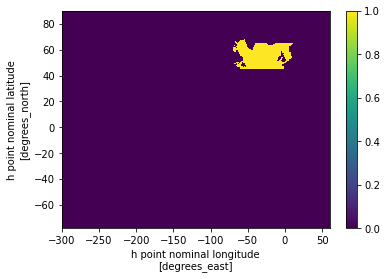

In [13]:
mask.plot()

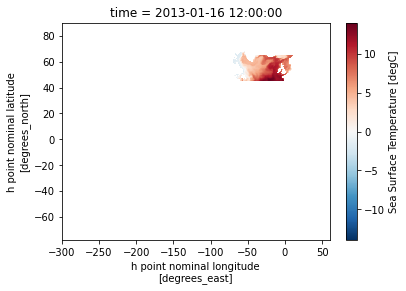

In [14]:
ds.where(mask).tos[0].plot()

### WMT calculation

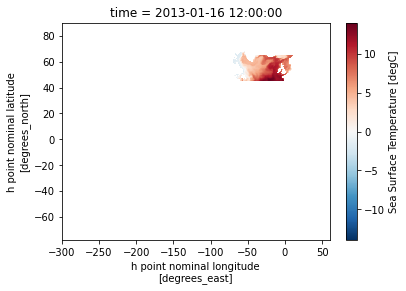

In [17]:
wmt(ds.where(mask)).ds.tos[0].plot()

In [18]:
# List all processes
wmt(ds).processes(False)

{'boundary forcing',
 'frazil ice',
 'geothermal',
 'neutral diffusion',
 'vertical diffusion'}

In [19]:
# Only list processes that are provided by the dataset
wmt(ds).processes()

['boundary forcing',
 'frazil ice',
 'geothermal',
 'vertical diffusion',
 'neutral diffusion']

In [20]:
# These processes are grouped in terms of heat and salt
wmt(ds).terms_dict

{'heat': 'thetao', 'salt': 'so'}

In [21]:
# Identify variables based on tendency and process
wmt(ds).process('heat','boundary forcing')

('thetao', 'boundary_forcing_heat_tendency')

In [22]:
wmt(ds).lambdas()

['theta', 'salt', 'sigma0', 'sigma1', 'sigma2', 'sigma3', 'sigma4']

In [23]:
wmt(ds).lambdas('density')

['sigma0', 'sigma1', 'sigma2', 'sigma3', 'sigma4']

In [15]:
lstr='sigma0'

if lstr == 'sigma0':
    lmin = 10
    lmax = 30
    dl = 0.1
elif lstr == 'theta':
    lmin = -2
    lmax = 30
    dl = 0.5
elif lstr == 'salt':
    lmin = 20
    lmax = 40
    dl = 0.1

In [25]:
wmt(ds.where(mask)).G(lstr,bins=np.arange(lmin,lmax,dl))

<xarray.Dataset>
Dimensions:             (time: 60, sigma0: 199)
Coordinates:
  * time                (time) object 2013-01-16 12:00:00 ... 2017-12-16 12:0...
  * sigma0              (sigma0) float64 10.05 10.15 10.25 ... 29.65 29.75 29.85
Data variables:
    boundary_forcing    (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>
    vertical_diffusion  (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>
    neutral_diffusion   (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>
    frazil_ice          (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>
    geothermal          (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>

In [26]:
wmt(ds.where(mask)).G(lstr,'boundary forcing', bins=np.arange(lmin,lmax,dl))

<xarray.DataArray 'boundary_forcing' (time: 60, sigma0: 199)>
dask.array<add, shape=(60, 199), dtype=float64, chunksize=(60, 199), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2013-01-16 12:00:00 ... 2017-12-16 12:00:00
  * sigma0   (sigma0) float64 10.05 10.15 10.25 10.35 ... 29.65 29.75 29.85

In [27]:
wmt(ds.where(mask)).G(lstr,'boundary forcing', bins=np.arange(lmin,lmax,dl), group_process=True, group_tend=False)

<xarray.Dataset>
Dimensions:       (time: 60, sigma0: 199)
Coordinates:
  * time          (time) object 2013-01-16 12:00:00 ... 2017-12-16 12:00:00
  * sigma0        (sigma0) float64 10.05 10.15 10.25 10.35 ... 29.65 29.75 29.85
Data variables:
    forcing_heat  (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>
    forcing_salt  (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>

In [28]:
wmt(ds.where(mask)).G(lstr,'boundary forcing', bins=np.arange(lmin,lmax,dl), group_process=False, group_tend=False)

<xarray.Dataset>
Dimensions:                         (time: 60, sigma0: 199)
Coordinates:
  * time                            (time) object 2013-01-16 12:00:00 ... 201...
  * sigma0                          (sigma0) float64 10.05 10.15 ... 29.75 29.85
Data variables:
    boundary_forcing_heat_tendency  (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>
    boundary_forcing_salt_tendency  (time, sigma0) float64 dask.array<chunksize=(60, 199), meta=np.ndarray>

[########################################] | 100% Completed | 182.58 s


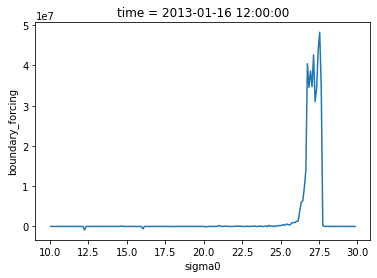

In [29]:
with ProgressBar():
    wmt(ds.where(mask)).G(lstr,'boundary forcing', bins=np.arange(lmin,lmax,dl))[0].plot()

In [30]:
dsG = wmt(ds.where(mask)).G(lstr, bins=np.arange(lmin,lmax,dl), group_tend=False)

### Save to files

In [ ]:
for v in dsG.keys():
    for yr in np.unique(dsG.time.dt.year):
        fname = subdir+'_%s_wmt_%s_%s_%s_yr%s.nc'%(basin_name, v, lstr, str(dl).replace('.','').ljust(3, '0'), str(yr).rjust(4, '0'))
        print('Saving to file:', fname)
        with ProgressBar():
            dsG.sel(time=str(yr).rjust(4, '0'))[v].to_dataset(name=v).reset_coords(drop=True).to_netcdf(fname, format='NETCDF4')

### Load from file

In [25]:
fnames = subdir+'_%s_wmt_*_%s_%s_yr*.nc'%(basin_name, lstr, str(dl).replace('.','').ljust(3, '0'))
dsG = xr.open_mfdataset(fnames)

In [27]:
# Save to single dataset
fname = subdir+'_%s_wmt_%s_%s.nc'%(basin_name, lstr, str(dl).replace('.','').ljust(3, '0'))
print('Saving to file:', fname)
with ProgressBar():
    dsG.reset_coords(drop=True).to_netcdf(fname, format='NETCDF4')

Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_sigma0_010.nc
[########################################] | 100% Completed |  0.2s


### Plots

In [29]:
dsG = xr.open_dataset(fname)

In [30]:
sum_of_components = xr.zeros_like(dsG.boundary_forcing_heat_tendency).rename('total')
components = [v for v in dsG.keys()]
for v in components:
    sum_of_components += dsG[v]

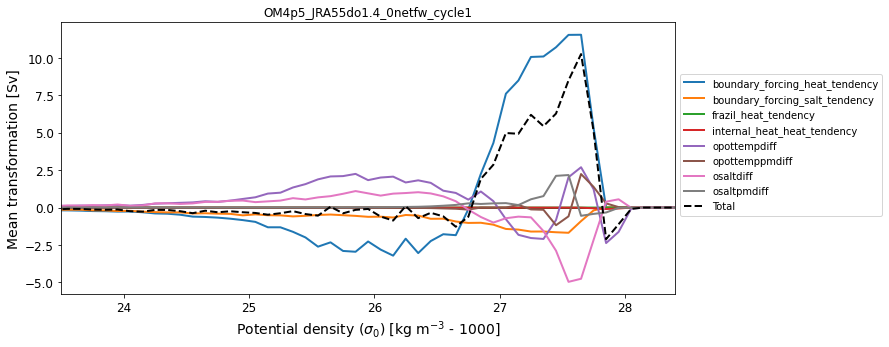

In [35]:
fig, ax = plt.subplots(figsize=(11,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

for v in dsG.keys():
    ax.plot(dsG[lstr], dsG[v].mean('time')*1e-6, lw=2, linestyle='-', label=v)
    
ax.plot(dsG[lstr], sum_of_components.mean('time')*1e-6, color='k', lw=2, linestyle='--', label='Total')
ax.set_xlim([23.5,28.4])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='center left',bbox_to_anchor=(1, 0.55))
ax.set_xlabel('Potential density ($\sigma_%s$) [kg m$^{-3}$ - 1000]'%lstr[-1],fontsize=14)
ax.set_ylabel('Mean transformation [Sv]',fontsize=14)
ax.set_title(subdir)
plt.show()

### Calculate thermodynamics beforehand

In [29]:
import momlevel as ml
import gsw

In [30]:
ds['pres'] = xr.apply_ufunc(gsw.p_from_z, -ds['lev'], ds['lat'], 0, 0, dask='parallelized')

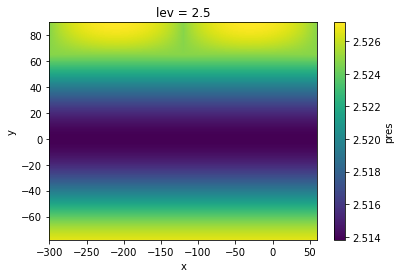

In [32]:
ds.pres[0].plot()

In [51]:
ds['alpha'] = ml.derived.calc_alpha(ds.thetao, ds.so, ds.pres)
ds['beta'] = ml.derived.calc_beta(ds.thetao, ds.so, ds.pres)

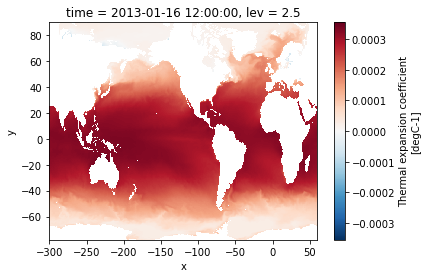

In [34]:
ds.alpha[0,0].plot()

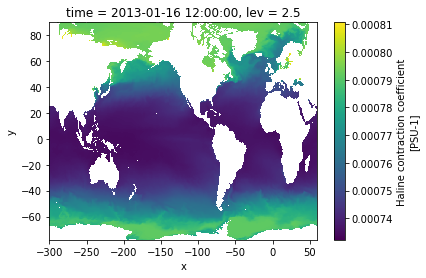

In [36]:
ds.beta[0,0].plot()

In [37]:
# momlevel uses Wright EOS to calculate density
ds['sigma0'] = ml.derived.calc_pdens(ds.thetao, ds.so, level=0.0)-1000

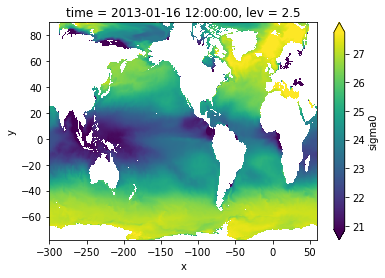

In [38]:
ds.sigma0[0,0].plot(robust=True)

In [39]:
dsG = wmt(ds.where(mask)).G(lstr, bins=np.arange(lmin,lmax,dl), group_tend=False)

In [40]:
for v in dsG.keys():
    for yr in np.unique(dsG.time.dt.year):
        fname = subdir+'_%s_wmt_wright_%s_%s_%s_yr%s.nc'%(basin_name, v, lstr, str(dl).replace('.','').ljust(3, '0'), str(yr).rjust(4, '0'))
        print('Saving to file:', fname)
        with ProgressBar():
            dsG.sel(time=str(yr).rjust(4, '0'))[v].to_dataset(name=v).reset_coords(drop=True).to_netcdf(fname, format='NETCDF4')

Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_internal_heat_heat_tendency_sigma0_010_yr2013.nc
[########################################] | 100% Completed | 193.66 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_internal_heat_heat_tendency_sigma0_010_yr2014.nc
[########################################] | 100% Completed | 176.96 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_internal_heat_heat_tendency_sigma0_010_yr2015.nc
[########################################] | 100% Completed | 175.13 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_internal_heat_heat_tendency_sigma0_010_yr2016.nc
[########################################] | 100% Completed | 168.00 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_internal_heat_heat_tendency_sigma0_010_yr2017.nc
[########################################] | 100% Completed | 196.81 s
Saving to file: OM4p5_JRA55do1.4_0n

In [42]:
fnames = subdir+'_%s_wmt_wright_*_%s_%s_yr*.nc'%(basin_name, lstr, str(dl).replace('.','').ljust(3, '0'))
dsG = xr.open_mfdataset(fnames)

# Save to single dataset
fname = subdir+'_%s_wmt_wright_%s_%s.nc'%(basin_name, lstr, str(dl).replace('.','').ljust(3, '0'))
print('Saving to file:', fname)
with ProgressBar():
    dsG.reset_coords(drop=True).to_netcdf(fname, format='NETCDF4')

Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_sigma0_010.nc
[########################################] | 100% Completed | 105.86 ms


### Comparison

In [48]:
dsG_gsw = xr.open_dataset('OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_sigma0_010.nc')
dsG_wright = xr.open_dataset('OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_sigma0_010.nc')

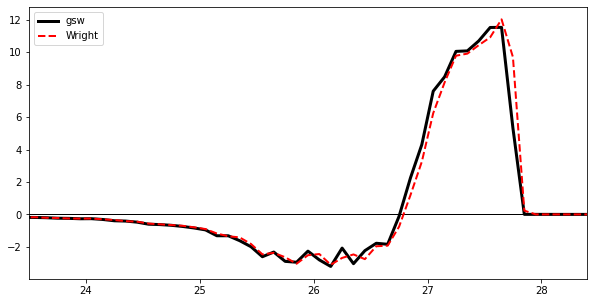

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(dsG_gsw.sigma0, dsG_gsw.boundary_forcing_heat_tendency.mean('time')*1e-6, color='k', linestyle='-', lw=3, label='gsw')
ax.plot(dsG_wright.sigma0, dsG_wright.boundary_forcing_heat_tendency.mean('time')*1e-6, color='r', linestyle='--', lw=2, label='Wright')
ax.legend(loc='upper left')
ax.set_xlim([23.5,28.4])
plt.show()

### Use MOM6 diagnostics (only availble for `OM4p5_JRA55do1.4_0netfw`)

In [29]:
# Thermal expansion coefficient (kg m-3 degC-1)
alpha = ds.drho_dT

# Haline contraction coefficient (kg^2 g-1 m-3 = kg m-3 * kg g-1 )
beta = ds.drho_dS

# Density kg/m^3
rho0 = 1035.0

In [30]:
# Remove calculated fiedls from previous section
#ds = ds.drop_vars(['alpha','beta','sigma0'])

#ds = ds.rename({'drho_dT':'alpha','drho_dS':'beta'})
ds['alpha'] = alpha/rho0*-1
ds['beta'] = beta/rho0

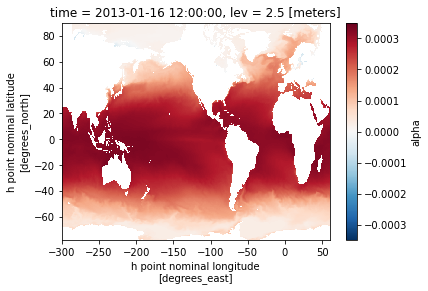

In [31]:
ds.alpha[0,0].plot()

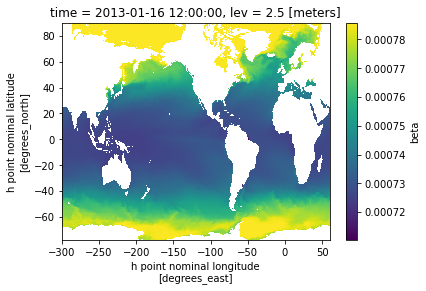

In [32]:
ds.beta[0,0].plot()

In [33]:
ds['sigma0'] = ds.rhopot0 - 1000

In [34]:
dsG = wmt(ds.where(mask)).G(lstr, bins=np.arange(lmin,lmax,dl), group_tend=False)

In [35]:
for v in dsG.keys():
    for yr in np.unique(dsG.time.dt.year):
        fname = subdir+'_%s_wmt_mom6_%s_%s_%s_yr%s.nc'%(basin_name, v, lstr, str(dl).replace('.','').ljust(3, '0'), str(yr).rjust(4, '0'))
        print('Saving to file:', fname)
        with ProgressBar():
            dsG.sel(time=str(yr).rjust(4, '0'))[v].to_dataset(name=v).reset_coords(drop=True).to_netcdf(fname, format='NETCDF4')

Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_mom6_boundary_forcing_heat_tendency_sigma0_010_yr2013.nc
[########################################] | 100% Completed | 147.11 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_mom6_boundary_forcing_heat_tendency_sigma0_010_yr2014.nc
[########################################] | 100% Completed | 142.83 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_mom6_boundary_forcing_heat_tendency_sigma0_010_yr2015.nc
[########################################] | 100% Completed | 131.45 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_mom6_boundary_forcing_heat_tendency_sigma0_010_yr2016.nc
[########################################] | 100% Completed | 126.23 s
Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_mom6_boundary_forcing_heat_tendency_sigma0_010_yr2017.nc
[########################################] | 100% Completed | 122.10 s
Saving to file: OM4p5_JRA55do1

In [16]:
fnames = subdir+'_%s_wmt_mom6_*_%s_%s_yr*.nc'%(basin_name, lstr, str(dl).replace('.','').ljust(3, '0'))
dsG = xr.open_mfdataset(fnames)

# Save to single dataset
fname = subdir+'_%s_wmt_mom6_%s_%s.nc'%(basin_name, lstr, str(dl).replace('.','').ljust(3, '0'))
print('Saving to file:', fname)
with ProgressBar():
    dsG.reset_coords(drop=True).to_netcdf(fname, format='NETCDF4')

Saving to file: OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_mom6_sigma0_010.nc
[########################################] | 100% Completed |  0.2s


### Comparison

In [17]:
dsG_gsw = xr.open_dataset('OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_sigma0_010.nc')
dsG_wright = xr.open_dataset('OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_wright_sigma0_010.nc')
dsG_mom6 = xr.open_dataset('OM4p5_JRA55do1.4_0netfw_cycle1_atlantic_subpN_wmt_mom6_sigma0_010.nc')

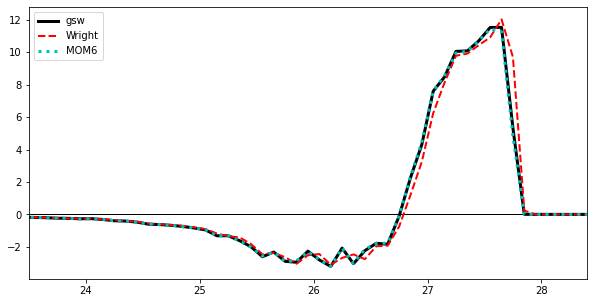

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(dsG_gsw.sigma0, dsG_gsw.boundary_forcing_heat_tendency.mean('time')*1e-6, color='k', linestyle='-', lw=3, label='gsw')
ax.plot(dsG_wright.sigma0, dsG_wright.boundary_forcing_heat_tendency.mean('time')*1e-6, color='r', linestyle='--', lw=2, label='Wright')
ax.plot(dsG_mom6.sigma0, dsG_mom6.boundary_forcing_heat_tendency.mean('time')*1e-6, color='c', linestyle=':', lw=3, label='MOM6')
ax.legend(loc='upper left')
ax.set_xlim([23.5,28.4])
plt.show()

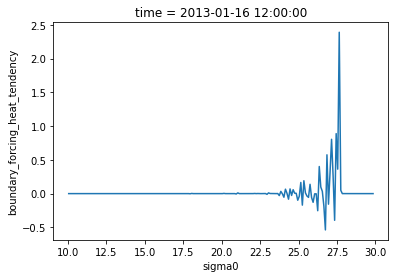

In [24]:
(dsG_gsw.boundary_forcing_heat_tendency*1e-6-dsG_mom6.boundary_forcing_heat_tendency*1e-6)[0].plot()

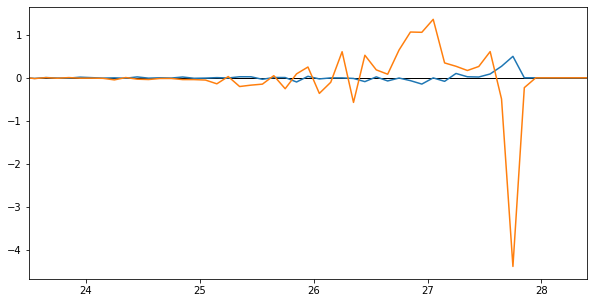

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(dsG_gsw.sigma0, dsG_gsw.boundary_forcing_heat_tendency.mean('time')*1e-6-dsG_mom6.boundary_forcing_heat_tendency.mean('time')*1e-6)
ax.plot(dsG_gsw.sigma0, dsG_gsw.boundary_forcing_heat_tendency.mean('time')*1e-6-dsG_wright.boundary_forcing_heat_tendency.mean('time')*1e-6)

ax.set_xlim([23.5,28.4])
plt.show()